## Build a contact network

# Download dataset

In [ ]:
#!wget https://lp-prod-resources.s3.amazonaws.com/628/66549/2021-06-25-19-30-14/PeopleLocations.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime as dt
from sklearn import preprocessing
from geopy.distance import geodesic 

In [2]:
# read in csv to pd.DataFrame
df = pd.read_csv("PeopleLocations.csv", sep = ";", 
                dtype={'id': np.str_, 'Lat': np.float32, 'Lon': np.float32})

In [3]:
# convert type to category
df["Covid19"] = df["Covid19"].astype("category")

In [4]:
# check the dtypes
df.dtypes

ID           object
Lat         float32
Lon         float32
Date         object
Time         object
Covid19    category
dtype: object

In [5]:
# rename the first column 
df.rename(columns={"ID": "IDcol"}, inplace=True)

In [6]:
# store the header of the first colum of dataframe df in variable "IDcol"
IDcol = df.columns[0]

# determine a list of different individuals for which there is at least one record in the csv file
uniquepart = df[IDcol].unique()

In [7]:
# a bit of the data
df.head(10)

,IDcol,Lat,Lon,Date,Time,Covid19
0,Person1,60.185390,25.009689,09-06-2021,13:52:09,n
1,Person2,60.185387,25.009678,09-06-2021,13:52:09,n
2,Person3,60.185390,25.009695,09-06-2021,13:52:09,n
3,Person4,60.185390,25.009689,09-06-2021,13:52:09,y
4,Person5,60.185387,25.009672,09-06-2021,13:52:09,n
5,Person6,60.185394,25.009706,09-06-2021,13:52:09,n
6,Person7,60.185383,25.009668,09-06-2021,13:52:09,y
7,Person8,60.185387,25.009686,09-06-2021,13:52:09,n
8,Person9,60.185379,25.009634,09-06-2021,13:52:09,n
9,Person10,60.185387,25.009678,09-06-2021,13:52:09,n


In [8]:
# determine a list of different individuals for which there is at least one record in the csv file 
dups = df[df.IDcol.duplicated()]

# count the number of different individuals. this will be the number of nodes in the contace network 
no_of_nodes = df.shape[0]


f"They are no duplicates in the dataset. However, {no_of_nodes} is the number of nodes."

'They are no duplicates in the dataset. However, 300 is the number of nodes.'

In [9]:
# before transformation
df[["Covid19"]]

,Covid19
0,n
1,n
2,n
3,y
4,n
...,...
295,n
296,y
297,y
298,y


In [10]:
# preprocessing the dataframe: Covid19 column 
# 0 = no covid19, 1 = covid19 using sklearn.preprocessing.LabelEncoder 
# use apply() to apply the LabelEncoder to the Covid19 column
le = preprocessing.LabelEncoder()
df["Covid19"] = df[["Covid19"]].apply(le.fit_transform)

In [11]:
# after transformation
df[["Covid19"]]

,Covid19
0,0
1,0
2,0
3,1
4,0
...,...
295,0
296,1
297,1
298,1


In [12]:
no_of_nodes = df.shape[0]

In [13]:
# create a graph object
G = nx.Graph()

# add a node with index `nodeidx` to the graph object `G`
for nodeidx in range(no_of_nodes):
    # read in identifier of individual from list `uniquepart` and store in variable personid
    personid = uniquepart[nodeidx]
    
    # create dataframe dmydf by selecting all rows from dataframe `df` with attribute `ID` equal to `personid`
    dmydf = pd.DataFrame(df.loc[df['IDcol'] == personid].copy())
    
    # reset index of dataframe dmydf
    dmydf.reset_index(drop=True, inplace=True) 
    
    # read in latitude of first location recording in `dmydf` and store in variable `latitude`
    latitude=dmydf.loc[0,['Lat']][0]
    
    # read in longitude of first location recording in `dmydf` and store in variable `longitude`
    longitude=dmydf.loc[0,['Lon']][0]
    
    # read in Covid19 infection status of first location recording in `dmydf` and store in variable `valtmp`
    valtmp=dmydf.loc[0,['Covid19']][0]
    
    # use le.transform() to map the infection status `valtmp` as `y`->1 and `n`-> 0
    infected=dmydf[["Covid19"]].apply(le.fit_transform)
    
    # read in the date of the recording and store in variable date_tmp
    date_tmp = dt.datetime.strptime(dmydf.loc[0,['Date']][0], '%d-%m-%Y').date() 
    
    # read in the time of the recording and store in variable time_tmp
    time_tmp = dt.datetime.strptime(dmydf.loc[0,['Time']][0], '%H:%M:%S').time()
    
    # combine date and time of location recording using `datetime.combine()
    mydatetime = dt.datetime.combine(date_tmp, time_tmp)
    G.add_node(nodeidx)
#     G.nodes[nodeidx]["name"] = df.loc[nodeidx, "IDcol"]
#     G.nodes[nodeidx]["coords"] = np.array([df.loc[nodeidx, "Lat"], df.loc[nodeidx, "Lon"]])
#     G.nodes[nodeidx]["timestamp"] = df.loc[nodeidx, "Date"]
    G.nodes[nodeidx]["Rate"] = df.loc[nodeidx, "Covid19"]
    
    # for node with index `nodeidx`, add attribute "coords" with value being a numpy 
    #    array of length 2 with elements latitude and longitude
    G.nodes[nodeidx]['coords']= np.array([latitude,longitude])
    # for node with index `nodeidx`, add attribute "timestamp" with value given by variable "mydatetime"  
    G.nodes[nodeidx]['timestamp'] = mydatetime

In [14]:
# see graph nodes
# to see data add data=true
G.nodes(data=True)

NodeDataView({0: {'Rate': 0, 'coords': array([60.18539, 25.00969], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 1: {'Rate': 0, 'coords': array([60.185387, 25.009678], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 2: {'Rate': 0, 'coords': array([60.18539 , 25.009695], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 3: {'Rate': 1, 'coords': array([60.18539, 25.00969], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 4: {'Rate': 0, 'coords': array([60.185387, 25.009672], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 5: {'Rate': 0, 'coords': array([60.185394, 25.009706], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 6: {'Rate': 1, 'coords': array([60.185383, 25.009668], dtype=float32), 'timestamp': datetime.datetime(2021, 6, 9, 13, 52, 9)}, 7: {'Rate': 0, 'coords': array([60.185387, 25.009686], dtype=float32), 'timestamp': datetime.datetime

In [15]:
def geodesic_distance(nodeidx1, nodeidx2):
    '''
    distance between two individuals in meters

    Parameters
    ----------
    nodeidx1 : int
        index of first individual

    nodeidx2 : int
        index of second individual
    
    Returns
    -------
    dist : float
        distance between two individuals in meters

    Example
    -------
    >>> geodesic_distance(0, 1)
    0.0
    '''
    # get the coordinates of the two individuals
    coords1 = G.nodes[nodeidx1]["coords"]
    coords2 = G.nodes[nodeidx2]["coords"]
    # compute the distance between the two individuals
    dist = np.linalg.norm(coords1 - coords2)
    # return the distance in meters
    return dist

# if distance is below two meters connect individuals by and edge
for nodeidx1 in range(no_of_nodes):
    for nodeidx2 in range(no_of_nodes):
        if nodeidx1 != nodeidx2:
            dist = geodesic(G.nodes[nodeidx1]['coords'],G.nodes[nodeidx2]['coords']).meters
            if dist < 2:
                G.add_edge(nodeidx1, nodeidx2)

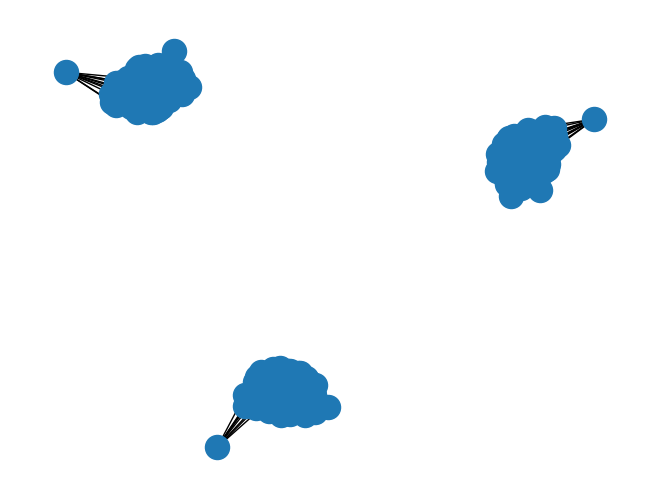

In [16]:
# visualize the graph
nc  = nx.draw(G,pos=nx.spring_layout(G))

# display figure using plt.show()

plt.show()

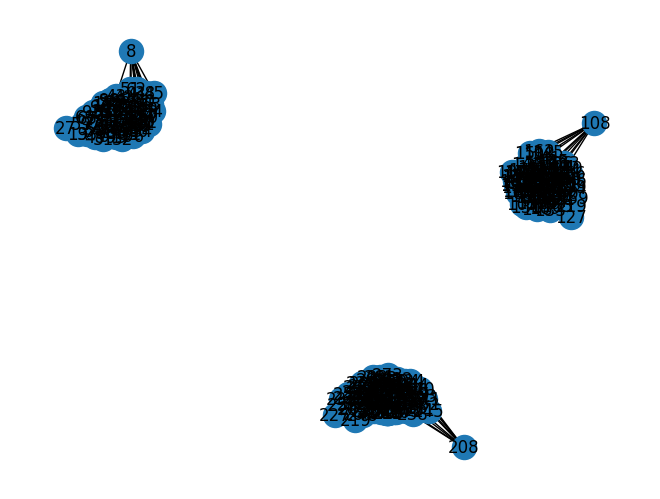

In [17]:
# change layout to spread out the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

## Infection Rate

In [19]:
# set variable "nriters" to 30
nriters=30

# create numpy array `W_MH` of shape (nrnodes,nrnodes) and with all entries zero

W_MH = np.zeros((no_of_nodes,no_of_nodes)) 

# loop over all edges in G.edges ()  

for edge in G.edges(): 
    # store first node of this edge in variable "node_a"
    node_a = edge[0]
    # store second node of this edge in variable "node_b"
    node_b = edge[1]
    # set entry W_MH[node_a,node_b] and W_MH[node_b,node_a] to MH weight  
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the contact network G
for nodedmy in G.nodes(): 
    # set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[nodedmy,nodedmy] = 1-np.sum(W_MH[nodedmy,:])
   
# loop over iterations for computing average infection rates

for iterdmy in range(nriters):
    # read in current values of "Rate" attributes into numpy array `graphsigold`
    graphsigold = np.fromiter(nx.get_node_attributes(G,'Rate').values(),dtype=float, count=no_of_nodes)
    
    # loop over all nodes in "G", use loop variable "node_i"
    for node_i in G.nodes(data=False):
        # set auxiliary variable "tmp" to 0 
        dmy = 0 
        # loop over all neighbours of current node "node_i"
        for node_j in G[node_i]: 
             dmy = dmy+W_MH[node_i,node_j]*graphsigold[node_j]#/(fac1*fac2)
        G.nodes[node_i]['Rate'] =W_MH[node_i,node_i]*graphsigold[node_i] + dmy

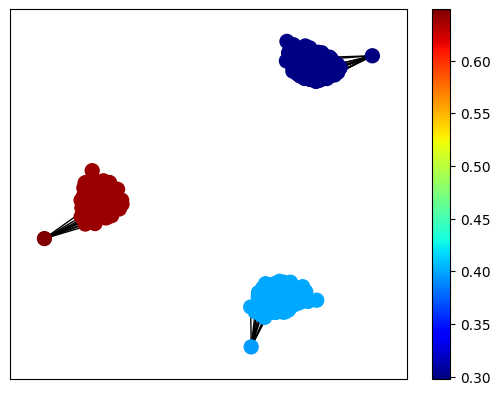

In [20]:
# create a NodeView object "nodes" for the nodes in the networkx graph "G" 
nodes = G.nodes()

# create a list of "Rate" attribute for all nodes in "G"
list_of_rates = [G.nodes[node_i]['Rate'] for node_i in nodes]

# create coordinates of nodes in figure using nx.spring_layout(G) 
pos = nx.spring_layout(G)

# draw edges of "G" using nx.draw_networkx_edges() 
ec  = nx.draw_networkx_edges(G, pos)

# use nx.draw_networkx_nodes() to draw nodes of "G" using node colours given by "Rate" value for each node
nc  = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=list_of_rates,
                             node_size=100, cmap=plt.cm.jet)

# add colorbar using plt.colorbar(); this needs as parameter the object returned by the above nx.draw_networkx_nodes()
plt.colorbar(nc)

# display figure using plt.show()

plt.show()

In [ ]:
# summary of notebook
# 1. read in data from csv file: ID, Lat, Lon, Date, Covid19
# 2. create networkx graph: nodes are individuals, edges are contacts
# 3. compute distance between individuals: if below 2 meters, connect by edge
# 4. create adjacency matrix: entries are 1 if connected, 0 otherwise
# 5. compute average infection rates: use Metropolis-Hastings algorithm where weights are given by degree of nodes
# 6. visualize graph: nodes are individuals, color is infection rate: red is high, blue is low

We create a graph from the CSV file. The nodes are the people and the edges are the contacts between them. If the individual is 2 meters away from another person, then there is no edge between them. If the individual is less than 2 meters away from another person, then there is an edge between them.

The infection rate is the probability that a person will be infected if they are in contact with an infected person. We assume that the infection rate is 0.5. This means that if a person is in contact with an infected person, then there is a 50% chance that they will be infected. The Metropolis-Hasitngs algorithm is used to sample the infection rate from a uniform distribution.

A heatmap is created to show the infection rate of the graph. The darker the color, the higher the infection rate. The lighter the color, the lower the infection rate. Red means that the infection rate is close to 1.0. Blue means that the infection rate is close to 0.0.